## Set up Environment

In [1]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'HSP_Binary_Class_Classifier_Using_Mistral_Fine_Tuned_Model_on_data_3.0.ipynb'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
!nvidia-smi

Thu May 23 11:58:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:21:00.0 Off |                    0 |
| N/A   33C    P0              66W / 300W |  29554MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import wandb
wandb.init('19010c4e439d59bec411f7f9075c6e73ac7f5e13')    # Initialize wandb with your API key
wandb.login()   # Authenticate with wandb.ai

wandb: Currently logged in as: yadav-sunil531984 (hsp_bits). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Import the Libraries

In [4]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification 
import evaluate
import numpy as np
from transformers import Trainer
from transformers import TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt

2024-05-23 11:58:35.041723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 11:58:35.828466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Data sets

Total Count of Samples =  4374


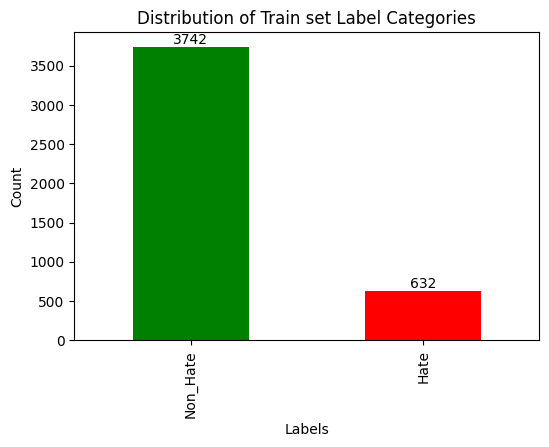

In [5]:
# Visualization of Class Labels Taining data
train_df=pd.read_csv('HSP_Train_Data_with_Encoded_Label_Bin_3.0.csv')

print("Total Count of Samples = ", len(train_df))
label_counts = train_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['green', 'red']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Train set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Total Count of Samples =  938


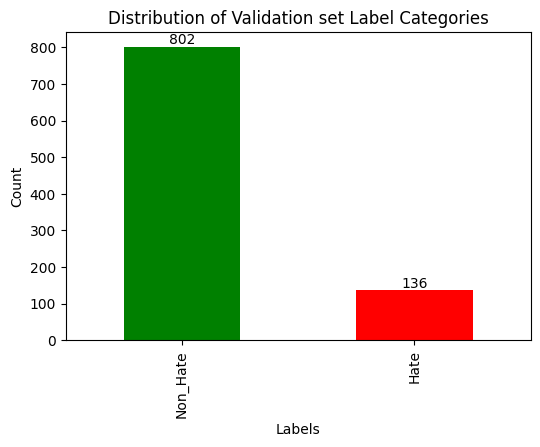

In [6]:
# Visualization of Class Labels Validation data
val_df = pd.read_csv('HSP_Val_Data_with_Encoded_Label_Bin_3.0.csv')

print("Total Count of Samples = ", len(val_df))
label_counts = val_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['green', 'red']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Validation set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Total Count of Samples =  938


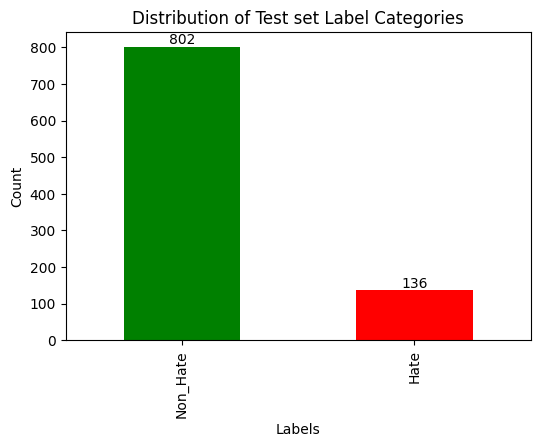

In [7]:
# Visualization of Class Labels Taining data
test_df=pd.read_csv('HSP_Test_Data_with_Encoded_Label_Bin_3.0.csv')

print("Total Count of Samples = ", len(test_df))
label_counts = test_df['Label'].value_counts()

# Updated colors list to include 6 colors for 6 classes
colors = ['green', 'red']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=colors)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Test set Label Categories')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [8]:
train_df=pd.read_csv('HSP_Train_Data_with_Encoded_Label_Bin_3.0.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4374 entries, 0 to 4373
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         4374 non-null   int64 
 1   Text       4374 non-null   object
 2   Label_Id   4374 non-null   int64 
 3   Label      4374 non-null   object
 4   Label_Rev  4374 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 171.0+ KB


In [9]:
unique_values = train_df['Label_Rev'].unique()
unique_values 

array([0, 1])

## Number of Characters

In [10]:
# Load the training data from the CSV file
train_df = pd.read_csv('HSP_Train_Data_with_Encoded_Label_Bin_3.0.csv')

# Calculate the maximum number of characters in the 'text' column
max_char = train_df['Text'].str.len().max()

# Calculate the maximum number of words in the 'text' column
max_words = train_df['Text'].str.split().str.len().max()

print(f"Maximum number of characters: {max_char}")
print(f"Maximum number of words: {max_words}")

Maximum number of characters: 1116
Maximum number of words: 97


## Preprocess Data for Training

In [11]:
MAX_LEN = 512 
mistral_checkpoint = "mistralai/Mistral-7B-v0.1"

In [12]:
# Load Mistral 7B Tokenizer
from transformers import AutoTokenizer, DataCollatorWithPadding
mistral_tokenizer = AutoTokenizer.from_pretrained(mistral_checkpoint, add_prefix_space=True)
mistral_tokenizer.pad_token_id = mistral_tokenizer.eos_token_id
mistral_tokenizer.pad_token = mistral_tokenizer.eos_token

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [13]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding

# Assuming mistral_tokenizer and MAX_LEN are defined earlier
def mistral_preprocessing_function(examples):
    return mistral_tokenizer(examples['Text'], truncation=True, max_length=MAX_LEN)

# Load each dataset file
train_dataset = load_dataset('csv', data_files='HSP_Train_Data_with_Encoded_Label_Bin_3.0.csv')['train']
val_dataset = load_dataset('csv', data_files='HSP_Val_Data_with_Encoded_Label_Bin_3.0.csv')['train'] # Assuming dev_data is for validation
test_dataset = load_dataset('csv', data_files='HSP_Test_Data_with_Encoded_Label_Bin_3.0.csv')['train']

# Define the columns to be removed
col_to_delete = ['id', 'Text', 'Label_Id', 'Label']

# Apply preprocessing to each dataset separately
mistral_tokenized_train_dataset = train_dataset.map(mistral_preprocessing_function, batched=True, remove_columns=col_to_delete)
mistral_tokenized_val_dataset = val_dataset.map(mistral_preprocessing_function, batched=True, remove_columns=col_to_delete)
mistral_tokenized_test_dataset = test_dataset.map(mistral_preprocessing_function, batched=True, remove_columns=col_to_delete)

# Rename the 'target' column to 'label' in each dataset
mistral_tokenized_train_dataset = mistral_tokenized_train_dataset.rename_column("Label_Rev", "label")
mistral_tokenized_val_dataset = mistral_tokenized_val_dataset.rename_column("Label_Rev", "label")
mistral_tokenized_test_dataset = mistral_tokenized_test_dataset.rename_column("Label_Rev", "label")

# Set format to 'torch' for all datasets
mistral_tokenized_train_dataset.set_format("torch")
mistral_tokenized_val_dataset.set_format("torch")
mistral_tokenized_test_dataset.set_format("torch")

# Data collator for padding a batch of examples to the maximum length seen in the batch
mistral_data_collator = DataCollatorWithPadding(tokenizer=mistral_tokenizer)
mistral_tokenized_train_dataset[0]

{'label': tensor(0),
 'input_ids': tensor([    1,  3194, 24057,  1658,   456,   575,   736, 28723,  5592,   315,
         28742, 28719, 11997, 28725,  5081,   315, 28742, 28719,  9393, 28725,
           304,  5081,   315, 28742,   333,  1484,   750,  1535,   749,   395,
          3561,   714, 28728,   848,   695,  1021, 28747, 10312, 28733,  3646,
          4759, 10294, 28747, 29096]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

## Load Pretrain Model

In [14]:
from transformers import AutoModelForSequenceClassification
import torch
mistral_model =  AutoModelForSequenceClassification.from_pretrained(
  pretrained_model_name_or_path=mistral_checkpoint,
  num_labels=2,
  device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-v0.1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# For Llama 2, we have to add the padding token id as it is not defined by default.
mistral_model.config.pad_token_id = mistral_model.config.eos_token_id

## LoRa setup for Mistral classifier

In [16]:
from peft import get_peft_model, LoraConfig, TaskType

mistral_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=2, lora_alpha=16, lora_dropout=0.1, bias="none", 
    target_modules=[
        "q_proj",
        "v_proj",
    ],
)

mistral_model = get_peft_model(mistral_model, mistral_peft_config)
mistral_model.print_trainable_parameters()

trainable params: 868,352 || all params: 7,111,528,448 || trainable%: 0.01221048339115074


## Setup the trainer

### Evaluation Metric

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate metrics using 'weighted' average for multi-class classification
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "accuracy": accuracy
    }

### Custom Trainer for Weighted Loss

In [18]:
class CELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Get model's predictions
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

### Custom Callback to Store Losses Once per Epoch

In [19]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []
        self.epoch = 0

    def on_epoch_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Append the most recent training loss to the list
        for log in reversed(state.log_history):
            if 'loss' in log:
                self.training_losses.append(log['loss'])
                break  # Ensure we only add one training loss per epoch

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        if len(self.training_losses) > len(self.validation_losses):
            # Append the most recent validation loss to the list
            for log in reversed(state.log_history):
                if 'eval_loss' in log:
                    self.validation_losses.append(log['eval_loss'])
                    break  # Ensure we only add one validation loss per epoch


In [20]:
loss_tracker_callback = LossTrackerCallback()

### Early Stopping Criteria

In [21]:
from transformers import EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

### Trainer setup

In [22]:
from transformers import TrainingArguments, Trainer

#mistral_model = mistral_model.cuda("cuda:1")

lr = 1e-4
batch_size = 8
num_epochs = 12

training_args = TrainingArguments(
    output_dir="mistral-lora-token-classification",
    learning_rate=lr,
    lr_scheduler_type= "constant",
    warmup_ratio= 0.1,
    max_grad_norm= 0.3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb",
    fp16=True,
    gradient_checkpointing=True,
)

In [23]:
mistral_trainer = CELossTrainer(
    model=mistral_model,
    args=training_args,
    train_dataset=mistral_tokenized_train_dataset,
    eval_dataset=mistral_tokenized_val_dataset,
    data_collator=mistral_data_collator,
    compute_metrics=compute_metrics,
    #callbacks=[loss_tracker_callback]
    callbacks=[loss_tracker_callback, early_stopping_callback]
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Model Training

In [24]:
# Start the training
train_result= mistral_trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1-score,Accuracy
1,1.295400,0.994102,0.808849,0.835821,0.818996,0.835821
2,0.819400,0.918724,0.808667,0.816631,0.812449,0.816631
3,0.697100,0.912556,0.816060,0.789979,0.801421,0.789979
4,0.573600,0.899643,0.827606,0.843284,0.834044,0.843284
5,0.497200,0.915434,0.827246,0.845416,0.834313,0.845416
6,0.453200,0.896066,0.824679,0.828358,0.826464,0.828358
7,0.428400,1.075171,0.811763,0.846482,0.821179,0.846482
8,0.362800,0.922303,0.818892,0.829424,0.823706,0.829424
9,0.326000,1.041726,0.811906,0.847548,0.820940,0.847548


/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/sunil/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=Fa

In [25]:
print(train_result)

TrainOutput(global_step=4923, training_loss=0.5821514296236258, metrics={'train_runtime': 658.1901, 'train_samples_per_second': 79.746, 'train_steps_per_second': 9.973, 'total_flos': 1.1310232545548698e+17, 'train_loss': 0.5821514296236258, 'epoch': 9.0})


In [26]:
eval_result = mistral_trainer.evaluate()
print(eval_result)

{'eval_loss': 0.8960657119750977, 'eval_precision': 0.8246786019881905, 'eval_recall': 0.8283582089552238, 'eval_f1-score': 0.8264641446154561, 'eval_accuracy': 0.8283582089552238, 'eval_runtime': 11.7026, 'eval_samples_per_second': 80.153, 'eval_steps_per_second': 10.083, 'epoch': 9.0}


## Analysis of Loss function and Evaluation of Trained Model

In [27]:
# Access the losses
training_losses = loss_tracker_callback.training_losses
validation_losses = loss_tracker_callback.validation_losses

print("Training Losses: ", training_losses)
print("Validation Losses: ", validation_losses)

Training Losses:  [1.2954, 0.8194, 0.6971, 0.5736, 0.4972, 0.4532, 0.4284, 0.3628, 0.326]
Validation Losses:  [0.9941017031669617, 0.9187237024307251, 0.9125558733940125, 0.8996426463127136, 0.9154338836669922, 0.8960657119750977, 1.0751713514328003, 0.9223029017448425, 1.0417261123657227]


In [28]:
print(len(training_losses ))
print(len(validation_losses ))

9
9


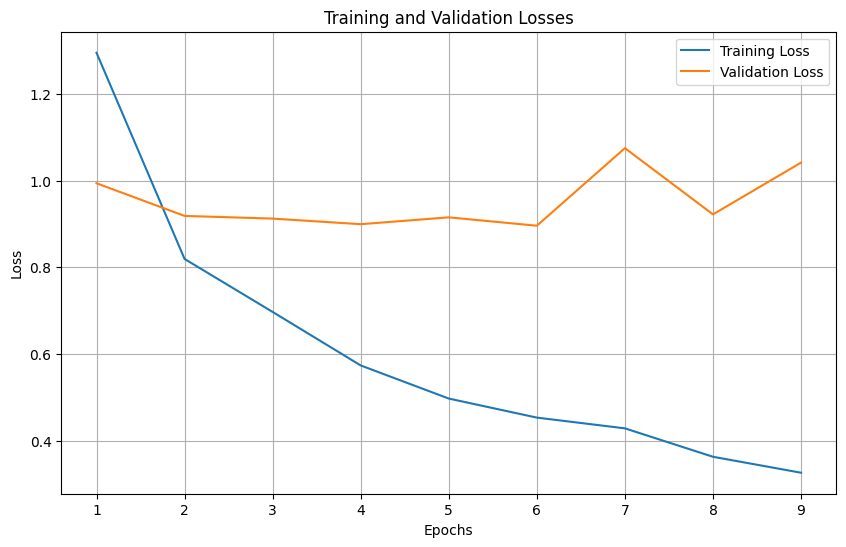

In [32]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

## Saving Model

In [25]:
!pwd

/home/sunil/Hate_Speech_Project/Mistral_Model


In [33]:
# Assuming `model_directory` is defined and points to where you want to save your model, tokenizer, and config
from transformers import AutoConfig
import os

# Define the directory where you want to save your model and tokenizer
model_directory = "/home/sunil/Hate_Speech_Project/Mistral_Model/mistral_finetuned_model_Bin"

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# First, save your trained model and tokenizer
mistral_model.save_pretrained(model_directory)
mistral_tokenizer.save_pretrained(model_directory)

# Then, save the configuration
config = AutoConfig.from_pretrained("mistralai/Mistral-7B-v0.1", num_labels=2) # Adjust as necessary
config.save_pretrained(model_directory)

print(f"Model, tokenizer, and configuration saved to {model_directory}")

Model, tokenizer, and configuration saved to /home/sunil/Hate_Speech_Project/Mistral_Model/mistral_finetuned_model_Bin


## Loading the Saved Model

In [34]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the directory where your saved model and tokenizer are
model_directory = "/home/sunil/Hate_Speech_Project/Mistral_Model/mistral_finetuned_model_Bin"

# Load the configuration and set the number of labels
config = AutoConfig.from_pretrained(model_directory, num_labels=2)

# Now, load the model with the updated configuration
model = AutoModelForSequenceClassification.from_pretrained(model_directory, config=config)

# Load the tokenizer as usual
#mistral_tokenizer = AutoTokenizer.from_pretrained(mistral_checkpoint, add_prefix_space=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory,add_prefix_space=True)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-v0.1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluation of Validation set

In [35]:
import pandas as pd
import torch
from torch.nn.functional import softmax

# Assuming tokenizer and model are already defined and loaded

def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Function to predict and store results in a new CSV
def predict_and_store(csv_file_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Ensure there's a column for predicted labels
    df['Predicted_Label'] = None
    
    # Iterate over each row in the DataFrame and make predictions
    for index, row in df.iterrows():
        text = row['Text']
        predictions = predict(text)
        predicted_class_index = predictions.argmax(dim=1).item()
        # Store the predicted class index in the DataFrame
        df.at[index, 'Predicted_Label'] = predicted_class_index
    
    # Define the name for the new CSV file that will contain the predictions
    predicted_csv_file_path = csv_file_path.replace('.csv', '_with_predictions.csv')
    
    # Save the modified DataFrame to the new CSV file
    df.to_csv(predicted_csv_file_path, index=False)
    
    # Log the creation of the new file with predictions
    print(f"Predictions stored in new file: {predicted_csv_file_path}")

# Example usage with your specific CSV file
csv_file_path = 'HSP_Val_Data_with_Encoded_Label_Bin_3.0.csv'
predict_and_store(csv_file_path)

Predictions stored in new file: HSP_Val_Data_with_Encoded_Label_Bin_3.0_with_predictions.csv


In [37]:
df = pd.read_csv("HSP_Val_Data_with_Encoded_Label_Bin_3.0_with_predictions.csv")
df.head()

,id,Text,Label_Id,Label,Label_Rev,Predicted_Label
0,2441,it makes me really mad that everyone says Scor...,1,Non_Hate,0,0
1,2948,Imagine invalidating an entire shows main char...,1,Non_Hate,0,0
2,5486,What do you prefer? #Longboard or #Surfboard ...,1,Non_Hate,0,0
3,6132,'s account is temporarily unavailable because ...,1,Non_Hate,0,0
4,1643,I mean id be a lesbian if I saw some of y'all ...,1,Non_Hate,0,0


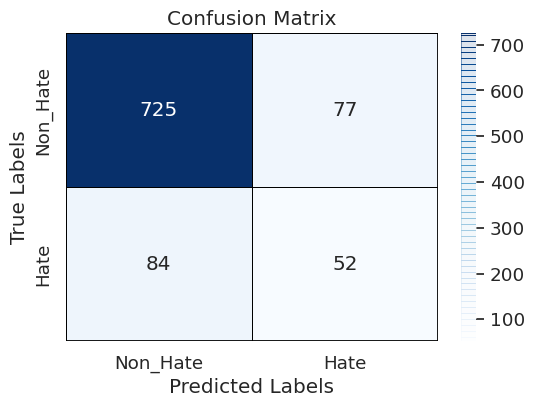

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV file containing text data
df = pd.read_csv("HSP_Val_Data_with_Encoded_Label_Bin_3.0_with_predictions.csv")

label_mapping = {0: "Non_Hate", 1: "Hate"}

# Generate the confusion matrix
confusion = confusion_matrix(df["Label_Rev"], df["Predicted_Label"])

# Create a heatmap of the confusion matrix with class labels
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),
                 linewidths=.5, linecolor='black', cbar_kws={'drawedges': True})  # Add cbar_kws parameter

# Add explicit border lines
ax.add_artist(plt.Line2D([0, len(label_mapping)], [len(label_mapping), len(label_mapping)], color='black', linewidth=2))
ax.add_artist(plt.Line2D([len(label_mapping), len(label_mapping)], [0, len(label_mapping)], color='black', linewidth=2))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Generate the classification report
classification_rep = classification_report(df["Label_Rev"], df["Predicted_Label"], target_names=list(label_mapping.values()))
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

    Non_Hate       0.90      0.90      0.90       802
        Hate       0.40      0.38      0.39       136

    accuracy                           0.83       938
   macro avg       0.65      0.64      0.65       938
weighted avg       0.82      0.83      0.83       938



## Evaluation of Test set

In [40]:
%%time
import pandas as pd
import torch
from torch.nn.functional import softmax

# Assuming tokenizer and model are already defined and loaded
def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Function to predict and store results in a new CSV
def predict_and_store(csv_file_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Ensure there's a column for predicted labels
    df['Predicted_Label'] = None
    
    # Iterate over each row in the DataFrame and make predictions
    for index, row in df.iterrows():
        text = row['Text']
        predictions = predict(text)
        predicted_class_index = predictions.argmax(dim=1).item()
        # Store the predicted class index in the DataFrame
        df.at[index, 'Predicted_Label'] = predicted_class_index
    
    # Define the name for the new CSV file that will contain the predictions
    predicted_csv_file_path = csv_file_path.replace('.csv', '_with_predictions.csv')
    
    # Save the modified DataFrame to the new CSV file
    df.to_csv(predicted_csv_file_path, index=False)
    
    # Log the creation of the new file with predictions
    print(f"Predictions stored in new file: {predicted_csv_file_path}")

# Example usage with your specific CSV file
csv_file_path = 'HSP_Test_Data_with_Encoded_Label_Bin_3.0.csv'
predict_and_store(csv_file_path)

Predictions stored in new file: HSP_Test_Data_with_Encoded_Label_Bin_3.0_with_predictions.csv
CPU times: user 1d 4h 40min 32s, sys: 7min 57s, total: 1d 4h 48min 30s
Wall time: 31min 27s


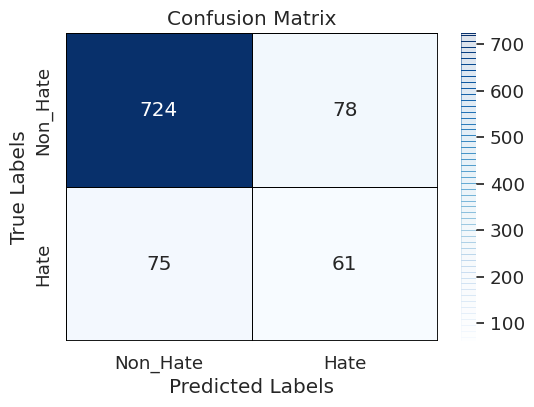

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV file containing text data
df = pd.read_csv("HSP_Test_Data_with_Encoded_Label_Bin_3.0_with_predictions.csv")

label_mapping = {0: "Non_Hate", 1: "Hate"}

# Generate the confusion matrix
confusion = confusion_matrix(df["Label_Rev"], df["Predicted_Label"])

# Create a heatmap of the confusion matrix with class labels
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),
                 linewidths=.5, linecolor='black', cbar_kws={'drawedges': True})  # Add cbar_kws parameter

# Add explicit border lines
ax.add_artist(plt.Line2D([0, len(label_mapping)], [len(label_mapping), len(label_mapping)], color='black', linewidth=2))
ax.add_artist(plt.Line2D([len(label_mapping), len(label_mapping)], [0, len(label_mapping)], color='black', linewidth=2))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# Generate the classification report
classification_rep = classification_report(df["Label_Rev"], df["Predicted_Label"], target_names=list(label_mapping.values()))
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

    Non_Hate       0.91      0.90      0.90       802
        Hate       0.44      0.45      0.44       136

    accuracy                           0.84       938
   macro avg       0.67      0.68      0.67       938
weighted avg       0.84      0.84      0.84       938



## General Inferencing

In [43]:
import torch
from torch.nn.functional import softmax

def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Example usage
text = "India is My Country"
predictions = predict(text)
predicted_class_index = predictions.argmax(dim=1).item()
print(f"Predicted class index: {predicted_class_index}")

Predicted class index: 0


In [44]:
import torch
from torch.nn.functional import softmax

def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Example usage
text = "I hate you, You are worst gay."
predictions = predict(text)
predicted_class_index = predictions.argmax(dim=1).item()
print(f"Predicted class index: {predicted_class_index}")

Predicted class index: 1


In [45]:
import torch
from torch.nn.functional import softmax

def prepare_input(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return inputs

def predict(text):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = prepare_input(text)
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=-1)
    return predictions

# Example usage
text = "LGBTQ+ people are also human, Give respect to save humanity."
predictions = predict(text)
predicted_class_index = predictions.argmax(dim=1).item()
print(f"Predicted class index: {predicted_class_index}")

Predicted class index: 0


In [46]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri May 24 09:32:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:21:00.0 Off |                    0 |
| N/A   29C    P0              66W / 300W |  59106MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--